# Hluboké zpětnovazební učení

Dneska se podíváme na hluboké zpětnovazební učení, které kombinuje dva námi už známé přístupy -- zpětnovazební učení a hluboké neuronové sítě. Tato technika umožňuje vytváření mocných agentů, kteří jsou schopni se trénovat pouze z her 'sám se sebou', jako jsou šachy, go apod. Díky tomu se dokázaly naučit hrát na úrovni lidských hráčů, ba je i překonávat.

## Zpětnovazební učení

Připomeňme si nejprve zpětnovazební učení, které jsme dělali na druhém cvičení. To spočívá v tom, že máme agenta a chceme ho nechat naučit se chovat v nějakém prostředí. Necháme tedy agenta vykonávat akce, díky kterým se bude přesouvat z jednoho stavu do dalšího a od prostředí za to bude dostávat odměnu, kterou se bude snažit maximalizovat. Takto se agent naučí strategii, jak se co nejlépe v daném prostředí chovat. Zpočátku bude provádět náhodné akce a spíše prozkoumávat prostředí, ale později se bude více snažit najít optimální řešení, čili maximalizovat svůj užitek za své chování. Nezapomeňme, že jednotlivé stavy, mezi kterými se agent přesouvá, nejsou nezávislé a dají se popsat Bellmannovými rovnicemi.

## Q-učení

Q-učení je druh zpětnovazebního učení, kde se agent učí pro každý stav a akci odhadovat odměnu, kterou dostane za provedení té akce v tom daném stavu. V klasickém Q-učení jsou tyto hodnoty reprezentované jako matice Q, která má jako řádky stavy a jako sloupce akce. Agent si postupně po pravedení akce v daném stavu updatuje hodnotu na odpovídajících souřadnicích v matici, aby pro příště věděl, jak výhodné je tu akci v tom stavu udělat. Problém je, když budeme mít prostředí s hodně stavy a akcemi, protože budeme mít obrovskou matici. To se dá vyřešit pomocí hlubokého Q-učení, kde místo matice Q, která pro každý stav a akci počítá odměnu, budeme používat neuronovou síť.


## Hluboké Q-učení

Dnes se tedy podíváme na agenta pro hluboké Q-učení, které kombinuje klasické Q-učení a neuronové sítě. Místo matice Q  agentovi definujeme model neuronové sítě, který bude předpovídat hodnoty funkce Q. Síť bude na vstupu dostávat stav a jako výstup bude vracet pravděpodobnosti toho, jak dobré je danou akci udělat. Trénování sítě bude potom probíhat tak, že se porovná aktuální odměna od prostředí s hodnotou spočtenou z Q a minimalizuje se MSE jejich rozdílu. Příklad je inspirován příkladem [odsud](https://keon.io/deep-q-learning/).

In [1]:
import random
from collections import deque
import tensorflow as tf
import numpy as np
import gym
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.nn import relu
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Implementace třídy agenta je celkem přímočará. Definujeme si síť s daným počtem vstupů a výstupů a nastavíme jí všechny parametry potřebné pro trénování Q-učení. Funkce ```build_model``` vytvoří model neuronové sítě se dvěma skrytými vrstvami,  funkce ```action``` vrací akci. Pokud trénujeme síť, používá epsilon-greedy strategii, pokud jen vyhodnocujeme, vrací nejlepší akci. Funkce ```train``` trénuje samotnou neuronovou síť a updatuje váhy.

Protože by ale update vah po každém kroku byl hrozně pomalý a navíc bychom ho dělali jen pro ten jeden poslední krok, uděláme to chytřeji a budeme trénovat síť pomocí tzv. bufferu. Do bufferu si pomocí funkce ```memorize``` budeme ukládat minulý stav, akci, odměnu, nový stav a příznak done, zda se jedná o cílový stav. Po každém kroku si z bufferu vybereme náhodnou trénovací množinu několika minibatchů, na jejichž základě upravíme váhy sítě tak, že spočítáme odměnu pro danou akci a druhou mocninou rozdílu odměny od prostředí a odměny od sítě spočítáme chybu, která se pak backpropaguje zpátky. Toto za nás udělá metoda ```fit```, jen jí musíme předat stavy a požadované výstupy.

Protože ale samotné trénování modelu trvá dlouho, napíšeme si ještě dvě funkce pro ukládání a načítání natrénovaného modelu, abychom nemuseli model přetrénovávat a mohli si ho rovnou nahrát s dříve předtrénovanými váhami. Funkce ```save_model``` pouze serializuje model a natrénované váhy do formátu json a uloží je. Funkce ```load_model``` nám naopak načte a nastaví agentovi uložený model a váhy rovnou bez trénovaní.

In [2]:
class DeepQLearningAgent:
    def __init__(self, num_inputs, num_outputs, batch_size = 8, num_batches = 16):
        self.num_inputs = num_inputs # state size
        self.num_outputs = num_outputs # action size
        
        self.batch_size = batch_size
        self.num_batches = num_batches
        
        self.epsilon = 1.0 
        self.epsilon_decay = 0.995      
        self.gamma = 0.95
        
        self.memory = deque(maxlen=2000)
        self.build_model()
        self.epsilon_min = 0.01
                 
    def build_model(self):
        self.model = Sequential([])
        self.model.add(Dense(24, activation=relu, input_dim=self.num_inputs, name='dense_11'))
        self.model.add(Dense(24, activation=relu))
        self.model.add(Dense(self.num_outputs, activation='linear'))
        
        opt = tf.keras.optimizers.Adam(lr=0.001)
        self.model.compile(optimizer=opt, loss='mse')
    
    def action(self, state, train=False):
        if train and np.random.uniform() < self.epsilon:
            return np.random.randint(self.num_outputs)
        else: 
            return np.argmax(self.model.predict(state)[0])

    def train(self):
        for _ in range(self.num_batches):
            
            # samplovani minibatche z pameti
            batch = random.sample(self.memory, self.batch_size)
            states = np.array([s for (s, _, _, _, _) in batch])
            next_states = np.array([ns for (_, _, _, ns, _) in batch])
            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))
            
            # predikce odmen za akce
            predicted = self.model.predict(states)
            next_predicted = self.model.predict(next_states)
                           
            # spocteni cilove hodnoty
            for i, (state, action, reward, next_state, done) in enumerate(batch):
                predicted[i][action] = reward
                if not done:
                    predicted[i][action] = reward + self.gamma*np.amax(next_predicted[i])

            self.model.fit(states, predicted, epochs=1, verbose=0)
                           
        # snizeni epsilon pro epsilon-greedy strategii
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay
    
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def save_model(self):
        model_json = self.model.to_json()
        
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
            
        self.model.save_weights("model.h5")
    
    def load_model(self): 
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights("model.h5")
        
        self.model = loaded_model

Když už máme napsaného agenta s hlubokým zpětnovazebním učením, vyzkoušíme si ho na nějakém zajímavém úkolu. Tentokrát si zkusíme prostředí [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/), kde máme tyčku na vozíku, který se pohybuje doprava nebo doleva. Cílem je, aby tyčka nespadla. Odměna +1 je získána za každý časový krok, kdy tyč zůstane vzpřímená. Epizoda končí, když je tyč více než 15 stupňů od svislé osy, nebo když se vozík posune více než 2.4 jednotky od středu.

Podíváme se tedy, jak toto prostředí vypadá a pro zajímavost si vypíšeme prostor pozorování a akcí.

In [3]:
env = gym.make('CartPole-v0')

print('observation space:', env.observation_space)
print('action space:', env.action_space)

env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


c:\users\katie\onedrive\dokumenty\documents\skola\matfyz\phd\prirodou-inspirovane-algoritmy\02_zpetnovazebne_uceni\gym\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Nyní už přejdeme k samotnému trénování. Stav zakódujeme do 4 hodnot a vytvoříme si agenta se 4 vstupy a 2 akcemi. Dále si vytvoříme prostředí a pomocné pole pro logování odměn. Pak už můžeme pustit samotné trénování na 1000 epochách a na závěr natrénovaný model uložit.

In [4]:
agent = DeepQLearningAgent(4, 2)
env = gym.make("CartPole-v1")
rewards = []

for i in range(1001):
    obs = env.reset()
    obs = np.reshape(obs, newshape=(1, -1))
    done = False
    R = 0
    t = 0
    while not done:
        old_state = obs
        action = agent.action(obs, train=True)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        r = r if not done else 10 # bonus za uplne vyreseni
        obs = np.reshape(obs, newshape=(1, -1))
        agent.memorize(old_state, action, r, obs, done)
    agent.train()
    
    rewards.append(R)
    if i % 100 == 0:
        print(i, R)
agent.save_model()

open_file = open('rewards.txt', "wb")
pickle.dump(rewards, open_file)
open_file.close()

0 12.0
100 20.0
200 72.0
300 71.0
400 44.0
500 31.0
600 201.0
700 160.0
800 109.0
900 177.0
1000 101.0


Vyzkoušíme, jak dobře náš agent umí problém řešit a zároveň si i zobrazíme animaci. Abychom nemuseli dlouho čekat na natrénování vah, načteme si ty předtrénované.

In [4]:
agent = DeepQLearningAgent(4, 2)
agent.load_model()

env = gym.make("CartPole-v1")
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
obs = np.reshape(obs, newshape=(1, -1))
done = False
R = 0
t = 0
while not done:
    env.render()
    old_state = obs
    action = agent.action(obs, train=False)
    obs, r, done, _ = env.step(action)
    obs = np.reshape(obs, newshape=(1, -1))
    R += r
    t += 1       
print(R)
env.close()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
144.0


Vykreslíme si výsledný graf odměn. Vidíme, že se celkově výsledky zlepšují, ale občas nám spadnou dolu. To se klidně může stát, protože vykreslujeme skóre z jedné hry a občas nějaká holt nevyjde.

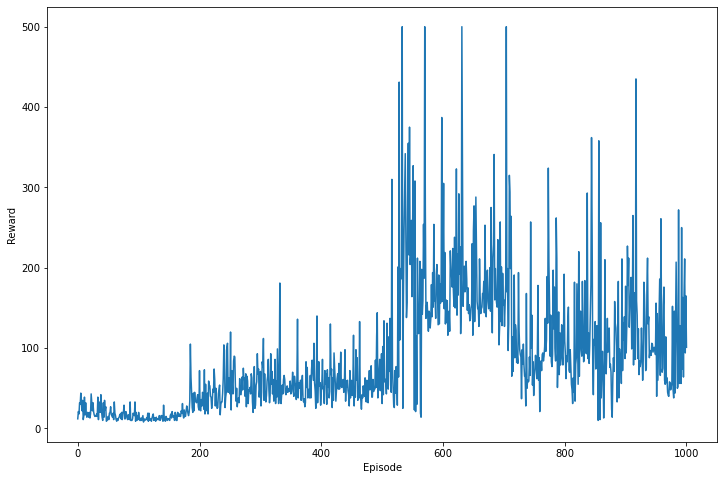

In [7]:
open_file = open('rewards.txt', "rb")
rewards = pickle.load(open_file)
open_file.close()

plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

## Úkol na cvičení

Vyberte si z [OpenAI gym](https://gym.openai.com/envs/) některý z problémů a zkuste ho vyřešit pomocí hlubokého Q-učení. Doporučuji si vybrat nějaké s diskrétními akcemi, ale můžete si klidně vybrat i akce spojité, jen je bude potřeba diskretizovat. V případě diskretizace je dobré mít těch akcí spíše méně, aby síť nemusela mít moc výstupů a netrénovala se příliš dlouho. 